## 합성곱 신경망

### 패션 MNIST CNN

- 

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [3]:
train_input.shape

(60000, 28, 28)

In [4]:
train_input.reshape(-1, 28, 28, 1).shape

(60000, 28, 28, 1)

In [5]:
# 255.0 - 정규화처리
# reshape(-1, 28, 28, 1) - 4차원 배열로 변경
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

In [6]:
train_scaled.shape

(60000, 28, 28, 1)

In [7]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [8]:
## 훈련세트, 검증세트 분리
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [9]:
print(train_scaled.shape, val_scaled.shape)
print(train_target.shape, val_target.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1)
(48000,) (12000,)


### 합성곱 신경망 만들기

In [10]:
model = keras.Sequential(name='CNN1')

# 32 -> 합생곱 층의 필터 갯수
# kernel_size -> (3x3)
# padding, same -> 패딩 추가해서 특성맵 사이즈를 원본과 동일하게
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))

In [11]:
model.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.add(keras.layers.MaxPooling2D(2))     # 특성맵이 반으로 줄어듬. 14x14 사이즈의 특성맵

In [13]:
model.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# 두번째 합성곱/풀링층 추가
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2)) # 사이즈 반으로, 7x7x64 특성맵 -> 3136 출력

In [15]:
# 심층신경망을 붙임
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

#### 위에 까지 학습을 위해서 나눠놓은 것
- 아래에 다시 하나의 셀에 합침

In [16]:
model = keras.Sequential(name='CNN1')

# 32 -> 합성곱 층의 필터 갯수
# kernel_size, 3 -> (3x3)
# padding, same -> 패딩 추가해서 특성맵사이즈를 원본과 동일하게
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1), name='First_CNN'))
model.add(keras.layers.MaxPooling2D(2, name='First_Pooling'))   # 특성맵이 반으로 줄어듬. 14x14 사이즈의 특성맵

# 두번째 합성곱/풀링층 추가
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', name='Second_CNN'))
model.add(keras.layers.MaxPooling2D(2, name='Second_Pooling'))  # 사이즈 반으로, 7x7x64 특성맵 -> 3136 출력

# 심층신경망을 붙임
model.add(keras.layers.Flatten(name='Flatten'))
model.add(keras.layers.Dense(100, activation='relu', name='Hidden'))
model.add(keras.layers.Dropout(0.4, name='Dropout'))  
model.add(keras.layers.Dense(10, activation='softmax', name='Output'))

In [17]:
model.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_CNN (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 First_Pooling (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 Second_CNN (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 Second_Pooling (MaxPooling  (None, 7, 7, 64)          0         
 2D)                                                             
                                                                 
 Flatten (Flatten)           (None, 3136)              0         
                                                                 
 Hidden (Dense)              (None, 100)               313700 

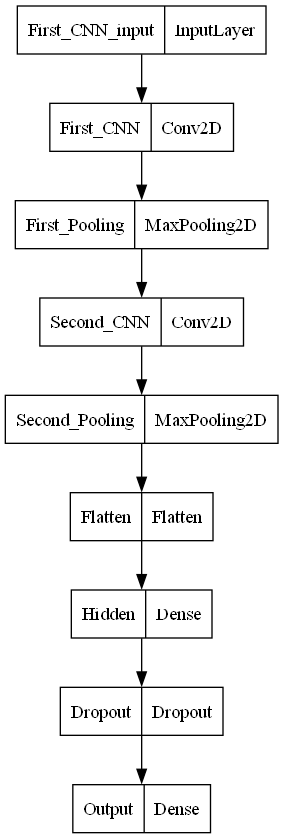

In [ ]:
# 모델 시각화 - 나중에
keras.utils.plot_model(model)

- graphviz설치
- pydot 파이썬 모듈 설치
- VS Code 재시작

In [19]:
!pip install pydot


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


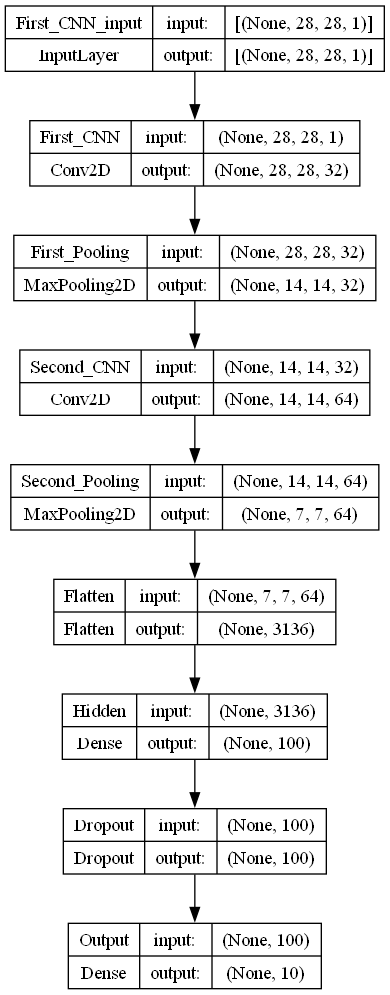

In [39]:
## 상세 모델 시각화
keras.utils.plot_model(model, show_shapes=True)

### 모델 컴파일, 훈련

In [20]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [21]:
# 모델 훈련
history = model.fit(train_scaled, train_target, epochs=50, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50


1500/1500 [==============================] - 8s 5ms/step - loss: 0.5194 - accuracy: 0.8151 - val_loss: 0.3277 - val_accuracy: 0.8812
Epoch 2/50
  27/1500 [..............................] - ETA: 6s - loss: 0.3630 - accuracy: 0.8623

c:\Source\iot-dataanalysis-2025\mlvenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 8s 5ms/step - loss: 0.3438 - accuracy: 0.8791 - val_loss: 0.2835 - val_accuracy: 0.8963
Epoch 3/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2925 - accuracy: 0.8956 - val_loss: 0.2556 - val_accuracy: 0.9032
Epoch 4/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2601 - accuracy: 0.9050 - val_loss: 0.2353 - val_accuracy: 0.9133
Epoch 5/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2341 - accuracy: 0.9137 - val_loss: 0.2280 - val_accuracy: 0.9153
Epoch 6/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2112 - accuracy: 0.9226 - val_loss: 0.2316 - val_accuracy: 0.9153
Epoch 7/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1956 - accuracy: 0.9270 - val_loss: 0.2182 - val_accuracy: 0.9183
Epoch 8/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1795 - accuracy: 0.9330 - val_loss: 0.2206 - val_accuracy: 0.9207
Epo

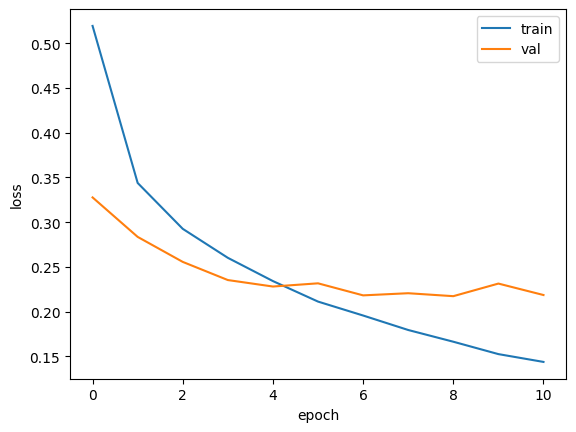

In [23]:
# 정확도 확인
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [24]:
# 모델 검증정확도
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2173 - accuracy: 0.9220


[0.217265784740448, 0.921999990940094]

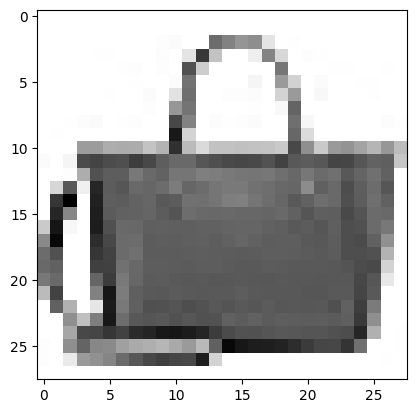

In [25]:
# val_scaled[0]
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.axis()
plt.show()

In [27]:
class_names = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

In [28]:
model.predict(val_scaled[0:1]).round(3)

1/1 [==============================] - 0s 16ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

### 예측시각화

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [30]:
# 한글로 Matplotlib 사용시 항상 필요
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus': False})

In [31]:
class_names = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

In [32]:
pred_result = model.predict(test_scaled)

313/313 [==============================] - 1s 2ms/step


In [33]:
# 테스트이미지와 예측결과 시각화
def show_image(index):
    plt.figure(figsize=(2,2))
    plt.imshow(test_input[index].reshape(28, 28), cmap='gray_r')
    true_label = class_names[test_target[index]]
    pred_label = class_names[np.argmax(pred_result[index])]

    #plt.title(f'실제: {true_label}, 예측: {pred_label}')
    plt.text(0, -6, f'실제: {true_label}', fontsize=12, color='blue')
    plt.text(0, -3, f'예측: {pred_label}', fontsize=12, color='red', fontweight='bold')

    plt.axis('off')
    plt.show()

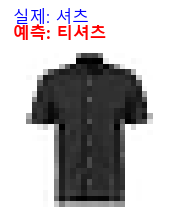

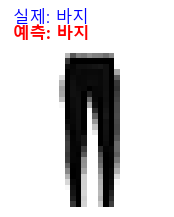

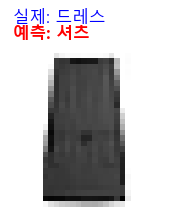

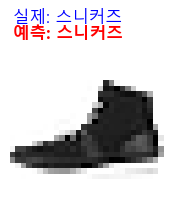

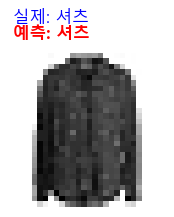

In [38]:
for i in range(40, 45):
    show_image(i)

In [37]:
## 테스트세트로 검증
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 2ms/step - loss: 0.2432 - accuracy: 0.9144


[0.2431516796350479, 0.9143999814987183]

#### 결론
- 일반신경망이나 심층신경망으로 훈련했을 때보다 정확도가 높아짐
- 심층신경망 : 대략 88%
- `합성곱신경망` : 대략 92%